In [ ]:
!pip install k-wave-python &> /dev/null

In [10]:
import matplotlib.pyplot as plt
import numpy as np

from kwave.data import Vector
from kwave.kgrid import kWaveGrid
from kwave.kmedium import kWaveMedium
from kwave.ksensor import kSensor
from kwave.ksource import kSource
from kwave.kspaceFirstOrder2D import kspaceFirstOrder2D
from kwave.options.simulation_execution_options import SimulationExecutionOptions
from kwave.options.simulation_options import SimulationOptions
from kwave.utils.conversion import cart2grid
from kwave.utils.kwave_array import kWaveArray
from kwave.utils.mapgen import make_cart_circle, make_disc
from kwave.utils.signals import reorder_binary_sensor_data

In [11]:
# define arc properties
radius = 100e-3  # [m]
diameter = 8e-3  # [m]
ring_radius = 50e-3  # [m]
num_elements = 20

# orient all elements towards the center of the grid
focus_pos = Vector([0, 0])  # [m]

element_pos = make_cart_circle(ring_radius, num_elements, focus_pos)

# create empty array
karray = kWaveArray()

for idx in range(num_elements):
    karray.add_arc_element(element_pos[:, idx], radius, diameter, focus_pos)

In [12]:

# medium properties
medium = kWaveMedium(sound_speed=1500)

# grid properties
N = Vector([256, 256])
d = Vector([0.5e-3, 0.5e-3])
kgrid = kWaveGrid(N, d)
# time array
kgrid.makeTime(medium.sound_speed)

(Vector([[0.000e+00, 1.000e-07, 2.000e-07, ..., 1.204e-04, 1.205e-04,
          1.206e-04]]),
 Vector(1.e-07))

In [5]:
source = kSource()
x_offset = 20  # [pixels]
# make a small disc in the top left of the domain
source.p0 = make_disc(N, Vector([N.x / 4 + x_offset, N.y / 4]), 4)
source.p0[99:119, 59:199] = 1
logical_p0 = source.p0.astype(bool)
sensor = kSensor()
sensor.mask = element_pos

In [6]:
simulation_options = SimulationOptions(
    save_to_disk=True,
    data_cast='single',
)

execution_options = SimulationExecutionOptions(is_gpu_simulation=True)
output = kspaceFirstOrder2D(kgrid, source, sensor, medium, simulation_options, execution_options)
_, _, reorder_index = cart2grid(kgrid, element_pos)
sensor_data_point = reorder_binary_sensor_data(output['p'].T, reorder_index=reorder_index)

# assign binary mask from karray to the source mask
sensor.mask = karray.get_array_binary_mask(kgrid)

output = kspaceFirstOrder2D(kgrid, source, sensor, medium, simulation_options, execution_options)
sensor_data = output['p'].T
combined_sensor_data = karray.combine_sensor_data(kgrid, sensor_data)


# create pml mask (re-use default size of 20 grid points from simulation_options)
pml_size = simulation_options.pml_x_size  # 20 [grid_points]
pml_mask = np.zeros((N.x, N.y), dtype=bool)
pml_mask[:pml_size, :] = 1
pml_mask[:, :pml_size] = 1
pml_mask[-pml_size:, :] = 1
pml_mask[:, -pml_size:] = 1

# Visualization

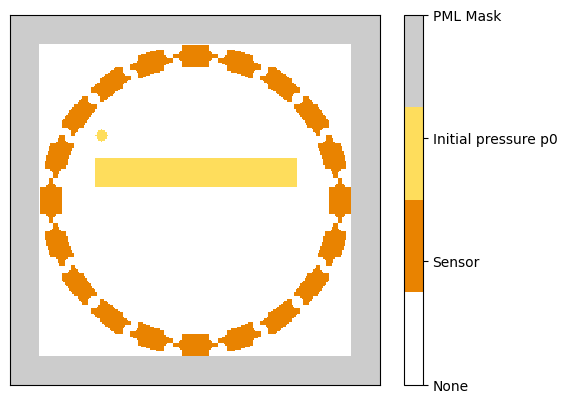

In [7]:
%matplotlib inline
# create pml mask (re-use default size of 20 grid points from simulation_options)
pml_size = simulation_options.pml_x_size  # 20 [grid_points]
pml_mask = np.zeros((N.x, N.y), dtype=bool)
pml_mask[:pml_size, :] = 1
pml_mask[:, :pml_size] = 1
pml_mask[-pml_size:, :] = 1
pml_mask[:, -pml_size:] = 1

# Plot source, sensor, and pml masks

# Assign unique values to each mask
sensor_val = sensor.mask * 1
logical_p0_val = logical_p0 * 2
pml_mask_val = pml_mask * 3

# Combine masks
combined_mask = sensor_val + logical_p0_val + pml_mask_val
combined_mask = np.flipud(combined_mask)

# Define custom colormap
colors = [
    (1, 1, 1),  # White (Background)
    (233/255, 131/255, 0/255),  # Orange (Sensor)
    (254/255, 221/255, 92/255),  # Yellow (Sources)
    (0.8, 0.8, 0.8),  # Light Grey (PML Mask)
]
cmap = plt.matplotlib.colors.ListedColormap(colors)

fig, ax = plt.subplots()
c = ax.pcolormesh(combined_mask, cmap=cmap, shading='auto')
plt.axis('image')

# Define labels for the colorbar
labels = {
    0: 'None',
    1: 'Sensor',
    2: 'Initial pressure p0',
    3: 'PML Mask',
}

colorbar = plt.colorbar(c, ticks=list(labels.keys()), ax=ax)
colorbar.ax.set_yticklabels(list(labels.values()))

ax.set_xticks([])
ax.set_yticks([])

plt.show()

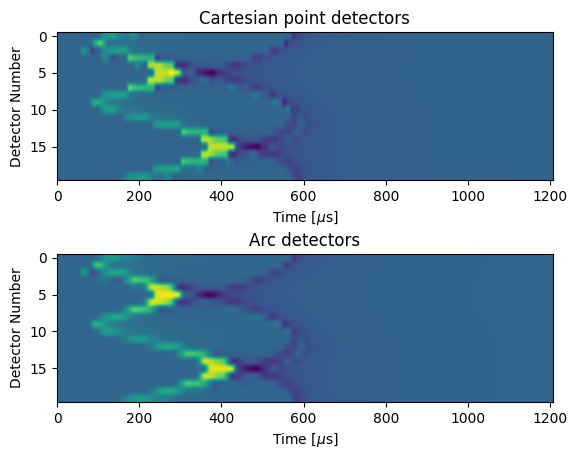

In [8]:
# Your existing code
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2)
ax1.imshow(sensor_data_point, aspect='auto')
ax1.set_xlabel(r'Time [$\mu$s]')
ax1.set_ylabel('Detector Number')
ax1.set_title('Cartesian point detectors')

ax2.imshow(combined_sensor_data, aspect='auto')
ax2.set_xlabel(r'Time [$\mu$s]')
ax2.set_ylabel('Detector Number')
ax2.set_title('Arc detectors')

# Add space between the plots
fig.subplots_adjust(hspace=0.5)  # Adjust the value as needed

fig.show()

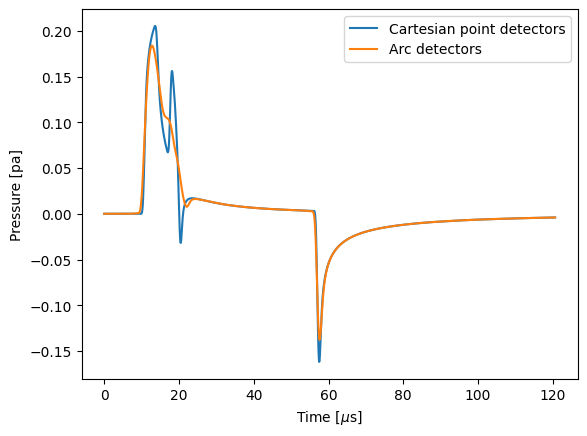

In [9]:
fig.subplots_adjust(hspace=0.5)

# Plot a trace from the recorded sensor data
fig = plt.figure()
plt.plot(kgrid.t_array.squeeze() * 1e6, sensor_data_point[0, :], label='Cartesian point detectors')
plt.plot(kgrid.t_array.squeeze() * 1e6, combined_sensor_data[0, :], label='Arc detectors')
plt.xlabel(r'Time [$\mu$s]')
plt.ylabel('Pressure [pa]')
plt.legend()
plt.show()